In [1]:
# default_exp calibrate

# Calibrate

> Calibration for the Open Source DIY Hyperspectral Imager. 

Calibration procedures include:
1. Crop to useable sensor area
2. Wavelength calibration for smile error
3. Find the camera image col index to wavelength map
4. Dark current subtraction
5. Flat field correction to get radiance from digital number
6. Radiance to Reflectance


In [2]:
#hide

# documentation extraction for class methods
from nbdev.showdoc import *

# unit tests using test_eq(...)
from fastcore.test import *

# monkey patching class methods using @patch
from fastcore.foundation import *
from fastcore.foundation import patch

# imitation of Julia's multiple dispatch using @typedispatch
from fastcore.dispatch import typedispatch

In [3]:
#export

import numpy as np
import matplotlib.pyplot as plt
import pickle
from PIL import Image
from fastcore.foundation import patch
import json


In [4]:
from openhsi.capture import *
from openhsi.utils import *

/Users/eway/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [5]:
#export
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from scipy import interpolate


In [25]:
openhsi_settings = settings_load("calibration_files/settings.txt")

#print(json.dumps(openhsi_settings,indent=4))

## Find illuminated sensor area

Since the longer dimension is used for the spectral channels, the rows correspond to the cross-track dimension and are limited by the optics (slit). The useable area is cropped out.

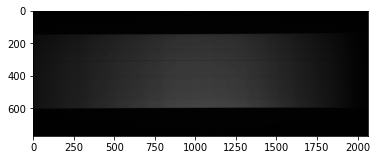

In [7]:
img = Image.open("calibration_files/flat_pic.png")
img = np.asarray(img,dtype=np.uint16)
plt.imshow(img,cmap="gray")

To take one of these images, see `OpenHSI.get_raw_img` in the capture module.

In [8]:
openhsi_settings["resolution"] = np.shape(img)

settings_dump("calibration_files/settings.txt",openhsi_settings)

In [9]:
#export

def row_minmax(img:np.ndarray,show:bool=False)->tuple:
    col_summed = np.sum(img,axis=1)
    edges = np.abs(np.gradient(col_summed))
    locs = find_peaks(edges, height=5000, width=1.5, prominence=0.01)[0]
    if show:
        plt.plot(col_summed)
        plt.plot([locs[0],locs[0]],[0,np.max(col_summed)],'r',alpha=0.5,label=f"{locs[0]}")
        plt.plot([locs[-1],locs[-1]],[0,np.max(col_summed)],'r',alpha=0.5,label=f"{locs[-1]}")
        plt.xlabel("row index")
        plt.legend()
    return (int(locs[0]),int(locs[-1]))

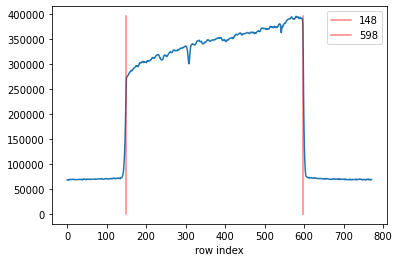

In [10]:
openhsi_settings["row_slice"] = row_minmax(img,show=True)
settings_dump("calibration_files/settings.txt",openhsi_settings)

## Smile Correction

The emissions lines, which should be straight vertical, appear slightly curved. This is smile error (error in the spectral dimension). 

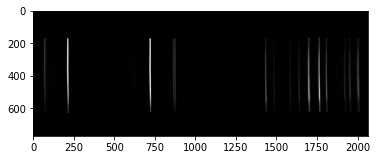

In [11]:
im2 = Image.open("calibration_files/HgAr_pic.png")
im2 = np.asarray(im2)
plt.imshow(im2,cmap="gray")

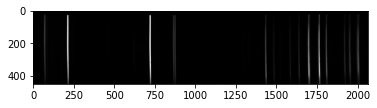

In [12]:
cropped_img = im2[slice(*openhsi_settings["row_slice"]),:]
HgAr = CircArrayBuffer((*np.shape(cropped_img),1),2)
HgAr.push(cropped_img)
HgAr.show()

In [13]:
#export

def find_smile_shifts(img:np.ndarray):
    sz = np.shape(img)
    window = np.int32(np.flip(img[202,:].copy()))
    
    shifts = np.zeros((sz[0],),dtype=np.int16)
    
    for i in range(sz[0]):
        pattern_match = np.convolve(img[i,:],window,"same")
        shifts[i] = np.argmax(pattern_match)
    
    shifts -= sz[1]//2
    shifts -= np.min(shifts) # make all entries positive
    return shifts



In [14]:
smile_shifts = find_smile_shifts(HgAr.data[:,:,0])

The <20 cross track index is not imaged well (emission lines are very weak on this edge of the image) and is the cause of this variability. Consider running `row_minmax` again with a well illuminated target. 

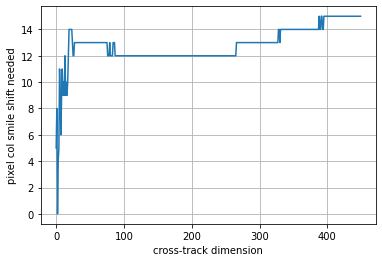

In [15]:
plt.plot(smile_shifts)
plt.xlabel("cross-track dimension")
plt.ylabel("pixel col smile shift needed")
plt.grid("on")

## Map the spectral axis to wavelengths

To do this, peaks in the HgAr spectrum are found, refined by curve-fitting with Gaussians. The location of the peaks then allow for interpolation to get the map from array (column) index to wavelength (nm).

In [16]:
#export

def sum_gaussians(x:"indices np.array", 
                    *args:"amplitude, peak position, peak width, constant") -> np.array:
    split = len(args)//3
    A   = args[0:split]         # amplitude
    mu  = args[split:2*split]   # peak position
    sigma = args[split*2:-1]    # peak stdev
    c   = args[-1]              # offset
    return np.array( [A[i] * np.exp( - np.square( (x - mu[i])/sigma[i] ) ) 
                        for i in range(len(A))] ).sum(axis=0) + c

In [17]:
#export

def fit_spectral_lines(spectra:np.array,spectral_lines:list,show=True):
    """finds the index to wavelength map given a spectra and a list of emission lines."""
    
    mu, props = find_peaks(spectra, height = 150, width = 1.5, prominence = 0.01)
    A = props["peak_heights"] # amplitude
    σ = 0.5 * props["widths"] # standard deviation
    c = 0.02                  # constant
    params0 = [*A,*mu,*σ,c]   # flatten to 1D array
    
    # refine the estimates from find_peaks by curve fitting Gaussians
    coeffs, _ = curve_fit(sum_gaussians, np.arange(len(spectra)), spectra, p0=params0)
    
    split = len(params0)//3
    A = coeffs[:split]
    μ = coeffs[split:2*split]
    σ = coeffs[2*split:-1]
    
    # find the array index for the top amplitude emissions lines
    top_A_idx = np.flip(np.argsort(A))[:len(spectral_lines)]
    sorted_idx = np.sort(μ[top_A_idx])
    
    # calculate the wavelength corresponding to each array index (should be straight)
    poly_func = np.poly1d( np.polyfit(sorted_idx, spectral_lines, 1) )
    wavelengths = poly_func(np.arange(len(spectra)))
    
    if show:
        plt.plot(wavelengths,spectra)
        plt.xlabel("wavelength (nm)")
        for i in np.uint16(np.round(sorted_idx)):
            plt.plot([wavelengths[i],wavelengths[i]],[0,np.max(spectra)],'r',alpha=0.5)
        plt.show()
    
    return wavelengths

In [18]:
#export

# top amplitude emission lines sorted in ascending order. You can use fewer entries if you'd like.
HgAr_lines = np.array([404.656,435.833,546.074,576.960,579.066,696.543,738.393,
                           750.387,763.511,772.376,794.818,800.616,811.531])


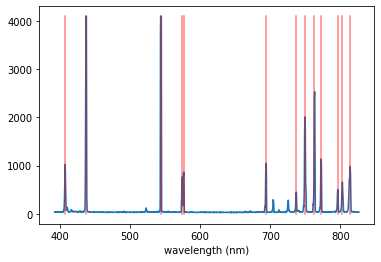

In [19]:
wavelength_map = fit_spectral_lines(HgAr.data[HgAr.size[0]//2,:,0],HgAr_lines)


Since we can spectrally resolve the 577 and 579 nm line, let's use a FWHM of 1.5 nm. 

In [20]:
openhsi_settings["fwhm_nm"] = 1.5

settings_dump("calibration_files/settings.txt",openhsi_settings)

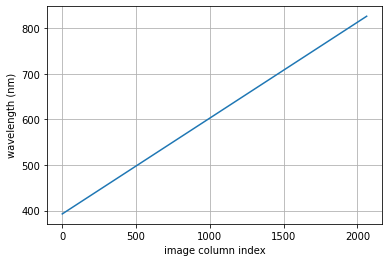

In [21]:
plt.plot(wavelength_map)
plt.xlabel("image column index")
plt.ylabel("wavelength (nm)")
plt.grid("on")

In [22]:
openhsi_settings["smile_shifts"] = [int(smile_shifts[i]) for i in range(len(smile_shifts))]

# save in a (range-similar) format that is (start,stop,step)
openhsi_settings["index2wavelength_range"] = (np.min(wavelength_map),np.max(wavelength_map),np.mean(np.gradient(wavelength_map)) )

settings_dump("calibration_files/settings.txt",openhsi_settings)

### Binning Spectral Pixels

You can even experiment with binning the spectral axis by changing the `fwhm_nm` parameter that goes into `DataCube`. The current FWHM for the OpenHSI camera we built is about 1.5 nm but if it were 20 nm, then the HgAr spectra would look like the following. 

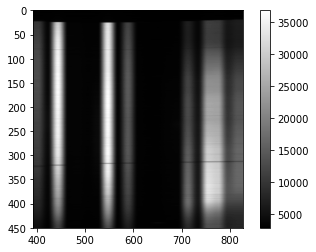

In [24]:
HgAr = DataCube(np.shape(im2),openhsi_settings["row_slice"],1,fwhm_nm=20,
                wavelength_range=openhsi_settings["index2wavelength_range"][:2])
HgAr.push(im2)
HgAr.show( (slice(None,None,None),0,slice(None,None,None)) )

> Note: The default datatype used by `DataCube` is `np.uint16` so if you bin too many spectral pixels together, you could get overflow. Change to a different datatype when using `DataCube`. 

## Dark Current Subtraction

## Digital Number to Radiance

Using an integrating sphere for even illumination and remove effects of vignetting.

## Radiance to Reflectance

Using a white (spectralon panel) target in the field of view as a reference.